In [1]:
# Copyright (c) 2023 Graphcore Ltd. All rights reserved.

import copy

import matplotlib.pyplot as plt
import matplotlib
import torch
import transformers

import llminference.methods.quantisation as Q

# Quantising whole models

Torch models can be quantised using `Q.quantise_model()`, which takes a list of `(pattern, format)` pairs. The pattern matches against the name from `module.named_parameters()`, and the matching format is used to quantise each tensor.

In [2]:
model = transformers.AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-160m")
base_model_bytes = 2 * sum(p.nelement() for p in model.parameters())

def error(qmodel: transformers.PreTrainedModel) -> float:
    return torch.mean(torch.stack([
        ((p - q) ** 2).mean().detach()
        for p, q in zip(model.parameters(), qmodel.parameters())
    ]))

spec =  [(".*", Q.FP16)]
qmodel = copy.deepcopy(model)
qbytes = Q.quantise_model(qmodel, spec)
print(f"Compressed size: {qbytes / base_model_bytes:.0%}")
print(f"Error: {error(qmodel):.2e}")

Compressed size: 100%
Error: 0.00e+00


In [3]:
spec = [
    ("embed_out", Q.channel_scaling_format(Q.parse("E2M5"), per="output")),
    (".*", Q.group_scaling_format(Q.parse("E0M3"), grouping="input", group_size=8, scale_format=Q.parse("E5M2"))),
]
qmodel = copy.deepcopy(model)
qbytes = Q.quantise_model(qmodel, spec)
print(f"Compressed size: {qbytes / base_model_bytes:.0%}")
print(f"Error: {error(qmodel):.2e}")

Compressed size: 36%
Error: 3.10e-06


In [4]:
spec = [
    ("embed_out", Q.channel_scaling_format(Q.parse("E2M5"), per="output")),
    (".*", Q.group_scaling_format(Q.parse("E0M3"), grouping="input", group_size=8,
                                  scale_format=Q.tensor_scaling_format(Q.ExpCeilFormat(4, 0), scale_format=Q.ExpCeilFormat(8, 0)))),
]
qmodel = copy.deepcopy(model)
qbytes = Q.quantise_model(qmodel, spec)
print(f"Compressed size: {qbytes / base_model_bytes:.0%}")
print(f"Error: {error(qmodel):.2e}")

Compressed size: 33%
Error: 6.37e-06


# Individual parameters

Parameter tensors can be quantised using `Q.LinearScalingFormat`, which picks per-(tensor, channel, group) scaling factors, based on `tensor.abs().max()`.

This provides the main functionality `quantise()` and `count_bits()`.

In [5]:
tensor = model.gpt_neox.layers[3].attention.query_key_value.weight.data

qtensor_tensor = Q.tensor_scaling_format(Q.parse("E0M3")).quantise(tensor)
qtensor_input = Q.channel_scaling_format(Q.parse("E0M3"), per="input").quantise(tensor)
qtensor_output = Q.channel_scaling_format(Q.parse("E0M3"), per="output").quantise(tensor)

group_format = Q.group_scaling_format(Q.parse("E0M3"), grouping="input", group_size=8)
qtensor_group = group_format.quantise(tensor)
print(f"           FP16 size: {Q.FP16.count_bits(tensor.shape) / 8 / 2**20:.2f} MB")
print(f"Group-quantised size: {group_format.count_bits(tensor.shape) / 8 / 2**20:.2f} MB")

           FP16 size: 3.38 MB
Group-quantised size: 1.27 MB


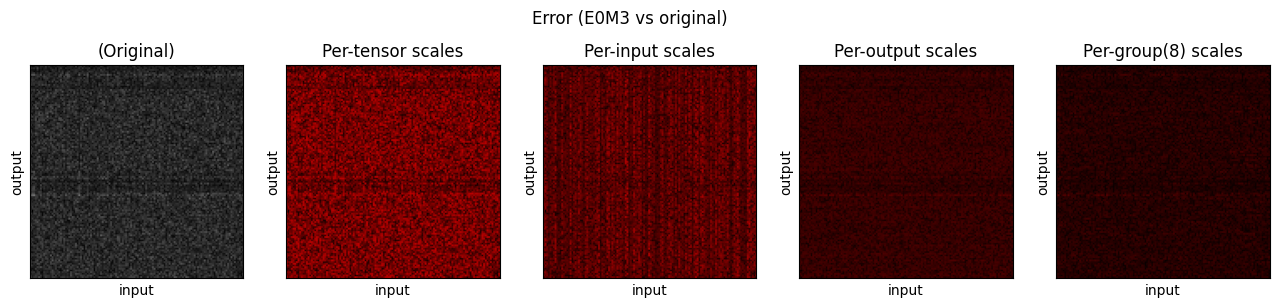

In [6]:
size = 128
norm = matplotlib.colors.PowerNorm(0.5, vmin=0, vmax=tensor.abs().max())

_, axs = plt.subplots(1, 5, figsize=(4*4, 4))
axs[0].imshow(tensor[:size, :size].abs(), cmap="gray", norm=norm)
axs[0].set_title("(Original)")

for ax, spec, qtensor in zip(axs[1:], ["tensor", "input", "output", "group(8)"], [qtensor_tensor, qtensor_input, qtensor_output, qtensor_group]):
    ax.imshow((tensor - qtensor)[:size, :size].abs(), cmap="hot", norm=norm)
    ax.set_title(f"Per-{spec} scales")

plt.suptitle("Error (E0M3 vs original)", y=0.9)
for ax in axs:
    ax.set_xticks([]) ; ax.set_yticks([])
    ax.set_xlabel("input") ; ax.set_ylabel("output")

# Scalar formats

Scalar formats subclass `Q.Format`, providing `max_absolute_value` as well as `quantise()` and `count_bits()`.

In [7]:
e2m1 = Q.parse("E2M1")
print(f"{e2m1} max value {e2m1.max_absolute_value}")

xs = torch.tensor([-1.8, 0, 5])
print(f"{xs} --> {e2m1} quantise --> {e2m1.quantise(xs)}")

E2M1 max value 3.0
tensor([-1.8000,  0.0000,  5.0000]) --> E2M1 quantise --> tensor([-2.,  0.,  3.])


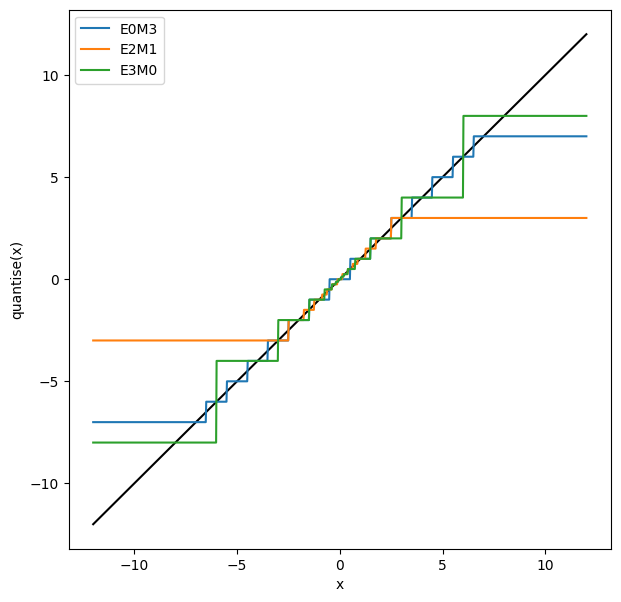

In [8]:
xs = torch.linspace(-12, 12, 1000)
plt.figure(figsize=(7, 7))
plt.plot(xs, xs, "k")
for fmt in [Q.parse("E0M3"),Q.parse("E2M1"),Q.parse("E3M0")]:
    plt.plot(xs, fmt.quantise(xs), label=str(fmt))
plt.legend()
plt.xlabel("x"); plt.ylabel("quantise(x)");